In [1]:
#imports
import pandas as pd
import numpy as np
from tensorflow.python.keras.layers import LeakyReLU
from tqdm import tqdm
from sklearn.model_selection import train_test_split as tts

In [2]:
#Variables
TRAIN_THRESHOLD = 0.8
DROPNAN = False

In [3]:
training = pd.read_csv('./ressources/training/training.csv')
#On enleve les NaN
if DROPNAN:
    training = training.dropna()
else:
    training.fillna(method = 'ffill',inplace = True)

In [4]:
X = training.Image.values
del training['Image']
Y = training.values
print(Y)

[[66.03356391 39.00227368 30.22700752 ... 72.93545865 43.13070677
  84.48577444]
 [64.33293617 34.9700766  29.9492766  ... 70.26655319 45.46791489
  85.48017021]
 [65.05705263 34.90964211 30.90378947 ... 70.19178947 47.27494737
  78.65936842]
 ...
 [66.69073171 36.84522146 31.66641951 ... 75.96359236 49.46257171
  78.11712   ]
 [70.96508235 39.85366588 30.54328471 ... 75.96359236 50.06518588
  79.58644706]
 [66.93831111 43.42450963 31.09605926 ... 75.96359236 45.90048
  82.7730963 ]]


In [5]:
tmp = []
for i in tqdm(X):
    q = [int(j) for j in i.split()]
    tmp.append(q)
len(tmp)

tmp = np.array(tmp)
print(tmp.shape)
tmp = tmp.reshape(X.shape[0], 96,96)
x = []
for i in range(0, len(tmp)):
    x.append(np.stack((tmp[i],)*3, axis=-1))
x = np.array(x)
x  = x/255.0
x.shape

100%|██████████| 7049/7049 [00:07<00:00, 989.33it/s] 


(7049, 9216)


(7049, 96, 96, 3)

In [6]:
print(x[0].shape)
print(tmp.shape)



(96, 96, 3)
(7049, 96, 96)


In [7]:
x_train,x_test,y_train,y_test = tts(x,Y,random_state = 69,test_size = 1-TRAIN_THRESHOLD)
x_train.shape

(5639, 96, 96, 3)

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout, Input, Flatten, Dense, Convolution2D, BatchNormalization,MaxPool2D
from tensorflow.keras.models import Model, Sequential

In [9]:
tf.test.is_gpu_available(cuda_only=True)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [10]:
#Fine tuning
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(96, 96, 3)))

headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(len(y_train[0]), activation="softmax")(headModel)

for layer in baseModel.layers:
	layer.trainable = False

model = Model(inputs=baseModel.input, outputs=headModel)
model.compile(optimizer = 'adam',loss = 'mean_squared_error', metrics = ['mae','acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [11]:
model.fit(x_train,y_train,batch_size=32, epochs=50,validation_data=(x_test,y_test))
model.save_weights("./checkpoints/CNN1.ckpt")

Epoch 1/50
177/177 [==============================] - 10s 32ms/step - loss: 2674.2457 - mae: 48.1927 - acc: 0.3457 - val_loss: 2669.3838 - val_mae: 48.1543 - val_acc: 0.3645

In [12]:
#CNN de zéro
model2 = Sequential()

model2.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,3)))
model2.add(LeakyReLU(alpha = 0.1))
model2.add(BatchNormalization())

model2.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model2.add(LeakyReLU(alpha = 0.1))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model2.add(LeakyReLU(alpha = 0.1))
model2.add(BatchNormalization())

model2.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model2.add(LeakyReLU(alpha = 0.1))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model2.add(LeakyReLU(alpha = 0.1))
model2.add(BatchNormalization())

model2.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model2.add(LeakyReLU(alpha = 0.1))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
# model2.add(BatchNormalization())
model2.add(LeakyReLU(alpha = 0.1))
model2.add(BatchNormalization())

model2.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model2.add(LeakyReLU(alpha = 0.1))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model2.add(LeakyReLU(alpha = 0.1))
model2.add(BatchNormalization())

model2.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model2.add(LeakyReLU(alpha = 0.1))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))

model2.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model2.add(LeakyReLU(alpha = 0.1))
model2.add(BatchNormalization())

model2.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model2.add(LeakyReLU(alpha = 0.1))
model2.add(BatchNormalization())


model2.add(Flatten())
model2.add(Dense(512,activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(30))
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        864       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0

In [13]:
model2.compile(optimizer = 'adam',loss = 'mean_squared_error', metrics = ['mae','acc'])
model2.fit(x_train,y_train,batch_size=32, epochs=50,validation_data=(x_test,y_test))
model2.save_weights("./checkpoints/CNN2.ckpt")

Epoch 1/50
177/177 [==============================] - 9s 38ms/step - loss: 228.6153 - mae: 8.6552 - acc: 0.3412 - val_loss: 127.2404 - val_mae: 10.0128 - val_acc: 0.6184

[[1.0011493e-29 8.4045156e-37 0.0000000e+00 0.0000000e+00 3.5121571e-28
  1.1005597e-35 3.2666848e-25 1.3164570e-38 6.4754430e-34 0.0000000e+00
  0.0000000e+00 6.8564037e-36 1.2810061e-31 3.0882519e-38 3.2782175e-26
  8.5936554e-37 6.0790937e-37 4.2749580e-37 3.5898377e-37 0.0000000e+00
  6.3892838e-37 2.4363892e-32 2.5981401e-30 6.4239729e-34 2.3804360e-36
  9.1671621e-26 8.8855140e-36 6.8252246e-27 4.1275379e-33 1.0000000e+00]]


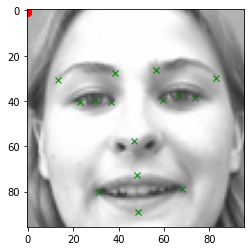

In [26]:
#Résultats CNN Fine-tuning
#Le vert représente la "vrai" valeur et le rouge ce qui est déduit par le CNN
from matplotlib import pyplot as plt

pred_model1  = model.predict(tf.expand_dims(tf.convert_to_tensor(x_test[11]), axis=0))
print(pred_model1)
plt.imshow(x_test[11])

for i in range(1,31,2):
    plt.plot(pred_model1[0][i-1], pred_model1[0][i], 'ro')
    plt.plot(y_test[11][i-1], y_test[11][i], 'x', color='green')

plt.show()

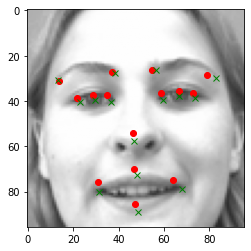

In [27]:
#Résultats CNN "de zero"
#Le vert représente la "vrai" valeur et le rouge ce qui est déduit par le CNN

pred_model2  = model2.predict(tf.expand_dims(tf.convert_to_tensor(x_test[11]), axis=0))

plt.imshow(x_test[11])

for i in range(1,31,2):
    plt.plot(pred_model2[0][i-1], pred_model2[0][i], 'ro')
    plt.plot(y_test[11][i-1], y_test[11][i], 'x', color='green')

plt.show()
